# Landmarks Path Computation
In this notebook, we train emotion models using the CK+ dataset.
- Read landmarks files and convert it to a normalized space.
- TODO: PCA to avoid unnecessary landmarks
- Based on the normalized landmarks, compute its patch regresssion.
- 

## Function to read and pre-process features from a file
The dataset contains landmarks computed using AAM. These landmarks are stored as a sequence of (x \n y \n) floats dots. Each frame has its own landmark file. To achieve a normalized feature set, it is set the nose as the reference point and the distance between the eyes as the reference size. For each landmark, the final feature is its distance to the reference point divided by the reference size.

In [1]:
using Distances
function readLandmarksFile(filename)
    # println("Getting features from: ", filename)
    
    # Database parser
    dots = map((x)->parse(x), split(readall(filename), ['\n', ' '], limit=0, keep=false));
    getLandmarkPoint(id) = [dots[id*2-1], dots[id*2]];
    
    # Reference Point: nose
    referenceID = 34
    referencePoint = getLandmarkPoint(referenceID)
    
    # Reference Size: distance between eyes
    referenceSize = evaluate(Euclidean(), getLandmarkPoint(40), getLandmarkPoint(43))
    if referenceSize < 1.0 error("Distance between eyes less than one.") end
    
    # Normalized vector
    normalizedVector = Float64[]
    for id = 1:round(Int,(length(dots) / 2))
        if id == referenceID; continue end
        append!(normalizedVector, (referencePoint - getLandmarkPoint(id)) / referenceSize)
    end
    
    return normalizedVector
end;
# readLandmarksFile("/home/data/ckplus/Landmarks/S100/001/S100_001_00000001_landmarks.txt")

readLandmarksFile (generic function with 1 method)

## Function to perform patch regression over the landmarks
Using the above function, all the landmarks from a video sequence are read and normalized. Then, for each landmark trajectory, it is computed its patch regression. The regression uses a second order polinomial function: a + bx + cx^2. The resulting vector contains the parameters [x0,xt,a,b,c] for each landmark patch.

In [2]:
# returns patch_xy[file][landmark*2]
function getPatchFeatures(dir)
    landmarks4frame = []
    for f = readdir("$dir")
        push!(landmarks4frame, readLandmarksFile("$dir/$f"))
    end
    return landmarks4frame
end;

In [3]:
# returns the (x y) patch for a given landmark
function splitXY(patch, landmark)
    x, y = Float64[], Float64[]
    for file = 1:round(Int, length(patch))
        push!(x, patch[file][landmark*2-1])
        push!(y, patch[file][landmark*2])
    end
    return x, y
end;

In [4]:
# return abcd (cubic) params for a given (x, y) patch
using LsqFit
function cubicRegression(x, y)
    model(x, p) = p[1] + p[2] * x + p[3] * x .^ 2 + p[4] * x .^ 3;
    fit = curve_fit(model, x, y, [0.,0.,0.,0.]);
    return fit.param
end;
function squareRegression(x, y)
    model(x, p) = p[1] + p[2] * x + p[3] * x .^ 2;
    fit = curve_fit(model, x, y, [0.,0.,0.]);
    return fit.param
end;

In [5]:
using Gadfly
function drawCubicCurve(x, y, param, title="no title")
    plot(layer(x=x, y=y, Geom.point, order=1),
         layer((x)->param[1] + param[2] * x + param[3] * x .^ 2 + param[4] * x .^ 3, minimum(x), maximum(x)),
         Guide.title(title))
end;
function drawSquareCurve(x, y, param, title="no title")
    plot(layer(x=x, y=y, Geom.point, order=1),
         layer((x)->param[1] + param[2] * x + param[3] * x .^ 2, minimum(x), maximum(x)),
         Guide.title(title))
end;

In [6]:
# performs regression for each landmark on a video clip
# returns [x0, xt, a, b, c] * lenght(landmarks), i.e. SVM ready
function landmarksRegressionParams(dir, debug=false)
    abc = Float64[]
    patch = getPatchFeatures(dir)
    for landmark = 1:floor(Int, length(patch[1]) / 2)
        x, y = splitXY(patch, landmark)
        p = []
        try
            p = squareRegression(x, y)
        catch
            warn("Landmark $landmark: Skipping regression due to an awesome error while performing curve fitting")
            p = [0.,0.,0.]
        finally
            push!(abc, minimum(x))
            push!(abc, maximum(x))
            append!(abc, p)
            if debug display(drawSquareCurve(x, y, p, "landmark: $landmark")) end            
        end
    end
    return abc
end;
# p = landmarksRegressionParams("/home/data/ckplus/Landmarks/S100/001");
# typeof(p)

landmarksRegressionParams (generic function with 2 methods)

In [7]:
using Gadfly
function drawLandmarksCurves(param)     # TODO - a not so hardcoded revision
    layers = Array{Gadfly.Layer,1}[]
    for i in 1:floor(Int, length(param) / 5)
        x0, xt, a, b, c = param[i*5-4], param[i*5-3], param[i*5-2], param[i*5-1], param[i*5]
        push!(layers, layer((x)->a+b*x+c*x.^2, x0, xt))
    end
    plot( layers[1], layers[2], layers[3], layers[4], layers[5], layers[6], layers[7], layers[8], layers[9], layers[10], layers[11], layers[12], layers[13], layers[14], layers[15], layers[16], layers[17], layers[18], layers[19], layers[20], layers[21], layers[22], layers[23], layers[24], layers[25], layers[26], layers[27], layers[28], layers[29], layers[30], layers[31], layers[32], layers[33], layers[34], layers[35], layers[36], layers[37], layers[38], layers[39], layers[40], layers[41], layers[42], layers[43], layers[44], layers[45], layers[46], layers[47], layers[48], layers[49], layers[50], layers[51], layers[52], layers[53], layers[54], layers[55], layers[56], layers[57], layers[58], layers[59], layers[60], layers[61], layers[62], layers[63], layers[64], layers[65], layers[66], layers[67], Guide.title("Facial Landmarks Patchs"))
end;
# drawLandmarksCurves(p)

drawLandmarksCurves (generic function with 1 method)

# Function to iterate over the CK+ dataset
For each sample, read the landmarks and the emotion result files. Using the above functions, the landmarks are transformed to an array of regression parameters. To perform the SVM trainning, the trainning matrix is composed by the regression parameters, where each row represent a sample video. In the same manner, the result matrix (for trainning) is composed by the emotion ID for the respective sample in the trainning matrix. So, for SVM trainning there are two matrixes, MTrainning: samples x (landmarks * regression_params), MTResults: samples x 1.

In [8]:
# read the sample file containing Emotion or FACS codes
function readResultFile(dir)
    results = []
    if !ispath(dir)
        return results
    end
    for a in readdir(dir)
        filename = "$dir/$a"
        append!(results, map((x)->convert(Int, parse(x)), split(readall(filename), ['\n', ' '], limit=0, keep=false)))
    end
    return(results)
end;
# readResultFile("/home/data/ckplus/Emotion/S005/001")

readResultFile (generic function with 1 method)

In [9]:
# iterate over all samples to mount the trainning matrix for svm: X <samples> x <landmarks * regression_params>
# returns also the path "$subject/$sample" referencing each sample in X
function loadTrainningSamples(dir)
    landmarksDir = "$dir/Landmarks"
    X, Path = Matrix, []
    first, c = true, 0
    for subjectDir = readdir(landmarksDir), sampleDir = readdir("$landmarksDir/$subjectDir")
        c += 1
        if (c % 100 == 0) println("$c") end
        row = []
        try
            row = landmarksRegressionParams("$landmarksDir/$subjectDir/$sampleDir")
        catch
            warn("$c: Skipping due to some bizarre error while loading landmarks regression parameters.")
            continue
        end
        if !first
            X = vcat(X, reshape(row, 1, size(row)[1]))
        else
            X = reshape(row, 1, size(row)[1])
            first = false
        end
        push!(Path, "$subjectDir/$sampleDir")
    end
    return X, Path
end
@time S, P = loadTrainningSamples("/home/data/ckplus");
# drawLandmarksCurves(S[100,:])

0.001557923441399917 (predicted_residual) >
0.001557923441399916 (residual) + 2.168404344971009e-19 (eps)


100


0.0015294840367033441 (predicted_residual) >
0.0015294840367033435 (residual) + 2.168404344971009e-19 (eps)
4.234172740529432e-7 (predicted_residual) >
3.999182640009279e-7 (residual) + 5.293955920339377e-23 (eps)
3.6977921460262776e-7 (predicted_residual) >
3.6977842723564926e-7 (residual) + 5.293955920339377e-23 (eps)
1.0198107162043539e-9 (predicted_residual) >
8.276141378370133e-10 (residual) + 2.0679515313825692e-25 (eps)
1.9430418844491996e-5 (predicted_residual) >
1.9430312308963642e-5 (residual) + 3.3881317890172014e-21 (eps)


200


4.430542572763326e-7 (predicted_residual) >
3.5104788717020695e-7 (residual) + 5.293955920339377e-23 (eps)
0.001147596165395189 (predicted_residual) >
0.0011475961653951883 (residual) + 2.168404344971009e-19 (eps)
7.495394329371154e-9 (predicted_residual) >
6.35277923127338e-9 (residual) + 1.6543612251060553e-24 (eps)
8.888489423428942e-9 (predicted_residual) >
6.926374952842766e-9 (residual) + 1.6543612251060553e-24 (eps)
1.9235731437968274e-9 (predicted_residual) >
4.382545052905591e-10 (residual) + 4.1359030627651384e-25 (eps)
7.081271774101576e-10 (predicted_residual) >
3.8173200146692075e-10 (residual) + 1.0339757656912846e-25 (eps)
5.343473613196792e-10 (predicted_residual) >
1.297106739017063e-10 (residual) + 1.0339757656912846e-25 (eps)
1.4296381341226259e-11 (predicted_residual) >
1.4295053813235453e-11 (residual) + 1.6155871338926322e-27 (eps)
2.8753400445053855e-9 (predicted_residual) >
2.7755603592186008e-9 (residual) + 4.1359030627651384e-25 (eps)
2.7531277325847847e-9 (pr

300


8.9738471153641e-5 (predicted_residual) >
8.973839072853483e-5 (residual) + 1.3552527156068805e-20 (eps)
3.390967930629293e-6 (predicted_residual) >
3.0368401124513785e-6 (residual) + 4.235164736271502e-22 (eps)
2.9001525203243127e-6 (predicted_residual) >
2.685801592200524e-6 (residual) + 4.235164736271502e-22 (eps)
2.5588937436908338e-6 (predicted_residual) >
2.5587606224300374e-6 (residual) + 4.235164736271502e-22 (eps)
1.2334930460592452e-9 (predicted_residual) >
1.2326673968168132e-9 (residual) + 2.0679515313825692e-25 (eps)
1.6785968352886283e-5 (predicted_residual) >
1.678596835121486e-5 (residual) + 3.3881317890172014e-21 (eps)
2.0610994024303835e-5 (predicted_residual) >
2.060109179108311e-5 (residual) + 3.3881317890172014e-21 (eps)
0.00010756292427752985 (predicted_residual) >
0.00010756292415505498 (residual) + 1.3552527156068805e-20 (eps)
9.51355755866774e-6 (predicted_residual) >
9.38398077916439e-6 (residual) + 1.6940658945086007e-21 (eps)
1.0468159695501117e-5 (predicted

400


9.689776598736821e-11 (predicted_residual) >
8.948132533862115e-11 (residual) + 1.2924697071141057e-26 (eps)
1.0518504807583791e-10 (predicted_residual) >
9.690371714379994e-11 (residual) + 1.2924697071141057e-26 (eps)
1.057682967955684e-10 (predicted_residual) >
1.046463426864003e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0601507396367237e-10 (predicted_residual) >
1.0501687689858915e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0385317764325274e-10 (predicted_residual) >
1.0305973003821524e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0372639311972102e-10 (predicted_residual) >
1.0305648154876176e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0276816626817959e-10 (predicted_residual) >
1.0190607658800393e-10 (residual) + 1.2924697071141057e-26 (eps)
1.0355885094116972e-10 (predicted_residual) >
1.0141144316377561e-10 (residual) + 1.2924697071141057e-26 (eps)
9.37349693718086e-11 (predicted_residual) >
8.66243540287484e-11 (residual) + 1.2924697071141057e-26 (eps)
3.57547859

500


1.1377298549779726e-6 (predicted_residual) >
1.1120757605120643e-6 (residual) + 2.117582368135751e-22 (eps)
1.1470516841008527e-6 (predicted_residual) >
1.1377539155565412e-6 (residual) + 2.117582368135751e-22 (eps)
6.165609718906536e-6 (predicted_residual) >
4.521833198283339e-6 (residual) + 8.470329472543003e-22 (eps)
3.982639782662421e-6 (predicted_residual) >
3.6734156399575105e-6 (residual) + 8.470329472543003e-22 (eps)
4.591791699234754e-6 (predicted_residual) >
3.784771921921588e-6 (residual) + 8.470329472543003e-22 (eps)
5.094468961947176e-6 (predicted_residual) >
4.592225143365345e-6 (residual) + 8.470329472543003e-22 (eps)
6.133777431620437e-6 (predicted_residual) >
5.09448940107295e-6 (residual) + 8.470329472543003e-22 (eps)
2.2185580966992264e-9 (predicted_residual) >
2.2184666658565977e-9 (residual) + 4.1359030627651384e-25 (eps)
0.0008685705970293279 (predicted_residual) >
0.0008685705970293276 (residual) + 1.0842021724855044e-19 (eps)
3.554332488753236e-10 (predicted_res

 69

(
592x335 Array{Float64,2}:
 2.1724   2.45148    -7.75328       7.14716   …     0.75713     -2.59951 
 1.72152  1.77917    92.5334     -106.073          -4.36074      6.25813 
 1.65541  2.03386    -0.370353      1.36193        -3.23221     -0.941804
 1.57829  1.61385     4.76672      -3.77731        16.8282     -38.0986  
 1.48594  1.50522  -405.763       540.439          -0.554909    -0.201765
 1.42433  1.69074    -7.49653       9.9837    …   166.598     -363.808   
 1.74008  1.86296    44.9633      -48.5741         -3.57407      5.09736 
 2.19071  2.23927   -60.5494       55.9889       -143.862      215.501   
 2.13604  2.54342    -3.88583       3.69105       -11.7142      23.1659  
 2.40624  2.54822   -16.3229       13.7422         -2.2061       2.21523 
 2.34023  2.66676     0.860191     -0.355273  …    -9.70775     19.0791  
 2.37413  2.43141   209.857      -176.215          57.5708    -105.04    
 2.41624  2.65596   -13.925        11.575           0.230861    -0.643761
 ⋮        

In [10]:
# todo: support facs
function parseSVM_XY(dir, samples, paths, key, debug = false)
    X, Y = Matrix{Float64}(0,size(samples)[2]) , []
    c = 0
    for p in paths
        c += 1
        if debug 
            if c > 10 break end
            println("--- $c: $p ---")
        end
        results = readResultFile("$dir/$p")
        if length(results) > 0
            for r in results
                ry = (r == key)? 1: -1
                X = vcat(X, samples[c,:])
                push!(Y, ry)
                if debug println("$c: $r -> $ry") end
            end
        else
            X = vcat(X, samples[c,:])
            push!(Y, -1)
            if debug println("$c: nothing -> -1") end
        end
    end
    return X, Y
end
# X, Y = parseSVM_XY("/home/data/ckplus/Emotion", S, P, 6)

.615397 seconds (113.80 M allocations: 10.728 GB, 2.10% gc time)


parseSVM_XY (generic function with 2 methods)

In [13]:
using RegERMs
function trainCKPlusEmotion(dir, samples, path)
    esvm = []
    for emotion in 1:7
        println("--- Emotion ID: $emotion ---")
        X, Y = parseSVM_XY(dir, samples, path, emotion)
        map = MercerMap(X, :linear)
        X = RegERMs.apply(map)
        model = optimize(SVM(X, Y; λ=0.1))
        push!(esvm, model)
    end
    return esvm
end
@time esvm = trainCKPlusEmotion("/home/data/ckplus/Emotion", S, P)

--- Emotion ID: 1 ---
--- Emotion ID: 2 ---
--- Emotion ID: 3 ---
--- Emotion ID: 4 ---
--- Emotion ID: 5 ---
--- Emotion ID: 6 ---
--- Emotion ID: 7 ---
993.

7-element Array{Any,1}:
 RegERMs.BinomialModel(RegERMs.LinearRegressionFunction(),[0.686563,0.686564,0.686564,0.686562,0.686563,0.686562,0.686563,0.686561,0.686566,0.686562  …  0.86797,-0.31242,0.251302,0.462245,-0.290109,-0.00538303,-0.0383074,-0.386259,1.39435,-0.358451])                                               
 RegERMs.BinomialModel(RegERMs.LinearRegressionFunction(),[0.0665988,0.0665992,0.0665996,0.0665989,0.0665997,0.0665997,0.0665995,0.0665993,0.0665997,0.0665993  …  0.150581,-0.788587,0.112256,0.176063,-0.295144,0.0409335,0.116002,-0.0458591,-0.0354153,-0.0135647])                                  
 RegERMs.BinomialModel(RegERMs.LinearRegressionFunction(),[-0.225089,-0.225089,-0.225088,-0.225088,-0.225088,-0.225089,-0.225089,-0.22509,-0.225088,-0.225087  …  -0.296597,-0.445967,-0.232912,-0.921702,1.03435,3.53582,0.365615,0.343892,0.089541,0.440042])                                          
 RegERMs.BinomialModel(RegERMs.LinearRegressionFunction(),[0.253262,0.253262,0.253

969758 seconds (1.54 G allocations: 820.255 GB, 11.79% gc time)


In [31]:
# make predictions and compute accuracy
for emotion in 1:7
    dir, samples, path = "/home/data/ckplus/Emotion", S, P

    X, Y = parseSVM_XY(dir, samples, path, emotion)
    map = MercerMap(X, :linear)
    X = RegERMs.apply(map)

    ybar = predict(esvm[emotion], X)
    acc = mean(ybar .== Y)

    println("> Emotion $emotion, accuracy: $acc")
end

> Emotion 1, accuracy: 0.777027027027027
> Emotion 2, accuracy: 0.7347972972972973
> Emotion 3, accuracy: 0.7905405405405406
> Emotion 4, accuracy: 0.5743243243243243
> Emotion 5, accuracy: 0.535472972972973
> Emotion 6, accuracy: 0.5304054054054054
> Emotion 7, accuracy: 0.7989864864864865


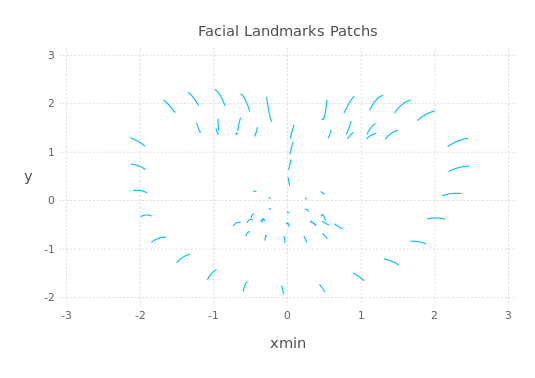

In [16]:
drawLandmarksCurves(S[1,:])